[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gonfiantini_1986/fig_3_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gonfiantini_1986/fig_3_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gonfiantini_1986/fig_3_1.ipynb)

### based on fig. 3-1. from [Gonfiantini 1968](https://doi.org/10.1016/B978-0-444-42225-5.50008-5).
Top panels show dependence of an isotopic composition of water $\delta$ to fraction of remaining water $f$. The bottom panel shows the change of the slope of the $\delta^2H$ to $\delta^{18}O$ relation.
Temperature was chosen arbitrary because author did not specify it.


In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from PySDM import Formulae
from PySDM.physics.constants import PER_MILLE, si, in_unit
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [3]:
def delta(*, delta_liq_0, remaining_water_fraction, humidity, delta_atmos, alpha, D_ratio_vs_light):
    """ eqs. 5, 7, 8, 9 in Gonfantini 1986"""
    Delta_eps = (1-humidity) * (1/D_ratio_vs_light - 1)
    eps = alpha - 1
    AB = lambda x: (x + Delta_eps + eps / alpha ) / (1 - humidity + Delta_eps)
    A = AB(humidity * delta_atmos)
    B = -AB(-humidity)
    return (delta_liq_0 - A/B) * remaining_water_fraction**B + A/B

In [4]:
formulae = Formulae(
    isotope_diffusivity_ratios='HellmannAndHarvey2020',
    isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994'
)
const = formulae.constants

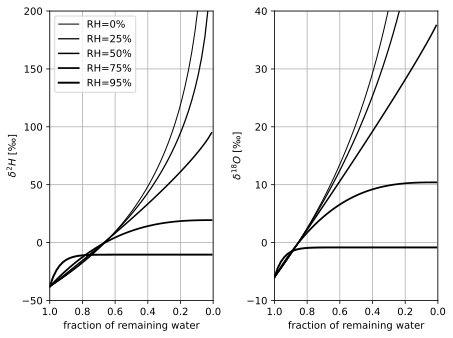

In [5]:
temperature = 300 * si.K
delta_0 = {
    '2H': -38 * PER_MILLE,
    '18O': -6 * PER_MILLE,
}
delta_a = {
    '2H': -86 * PER_MILLE,
    '18O': -12 * PER_MILLE,
}
plot_x = np.linspace(1, .01, 50)
humidities = (0, .25, .5, .75, .95)

fig, axs = pyplot.subplot_mosaic([delta_0.keys()], tight_layout=True)
plot_y = {}
for isotope, delta_0_i in delta_0.items():
    plot_y[isotope] = {}
    for h in humidities:
        plot_y[isotope][h] = delta(
            delta_liq_0=delta_0_i,
            remaining_water_fraction=plot_x,
            humidity=h,
            delta_atmos=delta_a[isotope],
            alpha=getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_l_{isotope}')(temperature),
            D_ratio_vs_light=getattr(formulae.isotope_diffusivity_ratios, f'ratio_{isotope}')(temperature)
        )
        axs[isotope].plot(
            plot_x,
            in_unit(plot_y[isotope][h], PER_MILLE),
            label=f'RH={h*100:.2g}%',
            color='k',
            linewidth=1 + h,
        )
        axs[isotope].set_xlim(1, 0)
        axs[isotope].set_xlabel("fraction of remaining water")
        axs[isotope].grid()
axs["2H"].legend()
axs["2H"].set_ylabel('$\\delta^2H$ [‰]')
axs["18O"].set_ylabel('$\\delta^{18}O$ [‰]')
axs["2H"].set_ylim(-50, 200)
axs["18O"].set_ylim(-10, 40)
show_plot('top_panels.pdf')

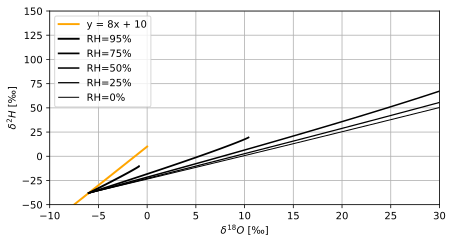

In [6]:
fig, ax = pyplot.subplots(figsize=(7,3.5))
x = np.linspace(-12, 0, 20) * PER_MILLE
ax.plot(
    in_unit(x, PER_MILLE),
    in_unit(const.CRAIG_1961_SLOPE_COEFF * x + const.CRAIG_1961_INTERCEPT_COEFF, PER_MILLE),
    label = f'y = {const.CRAIG_1961_SLOPE_COEFF}x + {in_unit(const.CRAIG_1961_INTERCEPT_COEFF, PER_MILLE):.2g}',
    color= 'orange',
    linewidth=2
)
for h in reversed(humidities):
    bottom_plot = ax.plot(
        in_unit(plot_y['18O'][h], PER_MILLE), 
        in_unit(plot_y['2H'][h], PER_MILLE),
        label=f'RH={h*100:.2g}%',
        color='k',
        linewidth=1 + h
    )
ax.set_xlim(-10, 30)
ax.set_ylim(-50, 150)
ax.set_xlabel('$\\delta ^{18}O$ [‰]')
ax.set_ylabel('$\\delta ^2H$ [‰]')
ax.grid()
ax.legend()
show_plot("bottom_panel.pdf")